Tutorial 2: Model Fitting
=========================

In this tutorial, we'll fit the 1D `Gaussian` model from the previous tutorial to data.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autofit as af
from os import path
import matplotlib.pyplot as plt
import numpy as np

/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace`


Load the dataset we will fit from the `autofit_workspace/dataset` folder.

In [2]:
dataset_path = path.join("dataset", "example_1d", "gaussian_x1")
data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))
noise_map = af.util.numpy_array_from_json(
    file_path=path.join(dataset_path, "noise_map.json")
)

The shape of the data gives us its xvalues, the x coordinates we evaluate our model 1D `Gaussian` on.

In [3]:
xvalues = np.arange(data.shape[0])
print(xvalues)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


Lets plot the data and noise-map we're going to fit.

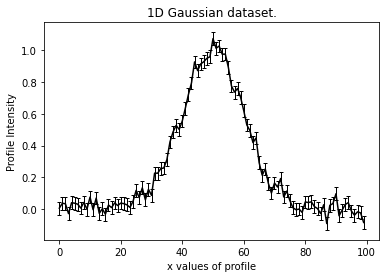

<Figure size 432x288 with 0 Axes>

In [4]:
plt.errorbar(
    xvalues, data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.title("1D Gaussian dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Profile Intensity")
plt.show()
plt.clf()

So, how do we actually go about fitting our `Gaussian` model to this data? First, we need to be able to generate
an image of our 1D `Gaussian` model. 

As we did in tutorial 1, we define the `Gaussian` as a Python class with the format required for **PyAutoFit** to use 
it as a model-component. This is again performed in the `gaussian.py` module of this tutorial.

In [5]:
import gaussian as g

We've extended the `Gaussian` class to have a method `profile_from_xvalues`. Given an input set of x coordinates
this computes the intensity of the `Gaussian` at every point. We've already seen how the data contains the xvalues we 
use, which are a 1D ndarray spanning values 0 to 100.

If we pass these values to an instance of the `Gaussian` class, we can create a line of the gaussian`s values.

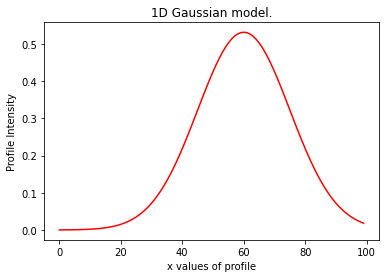

<Figure size 432x288 with 0 Axes>

In [6]:
model = af.PriorModel(g.Gaussian)
model.centre = af.UniformPrior(lower_limit=0.0, upper_limit=np.inf)
model.intensity = af.UniformPrior(lower_limit=0.0, upper_limit=np.inf)
model.sigma = af.UniformPrior(lower_limit=0.0, upper_limit=np.inf)

gaussian = model.instance_from_vector(vector=[60.0, 20.0, 15.0])

model_data = gaussian.profile_from_xvalues(xvalues=xvalues)

plt.plot(xvalues, model_data, color="r")
plt.title("1D Gaussian model.")
plt.xlabel("x values of profile")
plt.ylabel("Profile Intensity")
plt.show()
plt.clf()

It is often more informative to plot the `data` and `model_data` on the same plot for comparison.

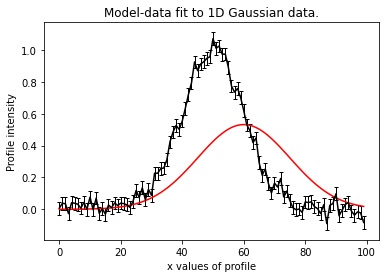

In [7]:
plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.plot(xvalues, model_data, color="r")
plt.title("Model-data fit to 1D Gaussian data.")
plt.xlabel("x values of profile")
plt.ylabel("Profile intensity")
plt.show()
plt.close()

Different values of `centre`, `intensity` and `sigma` change the `Gaussian``s appearance, have a go at editing some 
of the values above to see this behaviour.

Okay, so lets recap. We've defined a model which is a 1D `Gaussian` and given a set of parameters for that model
$(x, I, \sigma)$ we can create `model_data` of the `Gaussian`. And, we have some data of a 1D `Gaussian` we want to
fit this model with, so as to determine the values of $(x, I, \sigma)$ from which it was created. So how do we do that?

Simple, we take the image from our `data` and our `model_data` of the `Gaussian` and subtract the two to get a
residual-map.

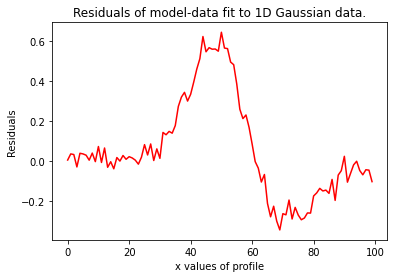

<Figure size 432x288 with 0 Axes>

In [8]:
residual_map = data - model_data
plt.plot(xvalues, residual_map, color="r")
plt.title("Residuals of model-data fit to 1D Gaussian data.")
plt.xlabel("x values of profile")
plt.ylabel("Residuals")
plt.show()
plt.clf()

Clearly, this model isn't a good fit to the data - which was to be expected as they looked nothing alike!

Next, we want to quantify how good (or bad) the fit actually was, via some goodness-of-fit measure. This measure
needs to account for noise in the data, after all if we fit a pixel badly simply because it was very noisy we want
our goodness-of-fit to account for that.

To account for noise, we take our `residual_map` and divide it by the `noise_map`, to get the normalized residual-map.

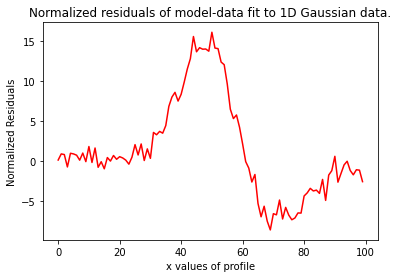

<Figure size 432x288 with 0 Axes>

In [9]:
normalized_residual_map = residual_map / noise_map
plt.plot(xvalues, normalized_residual_map, color="r")
plt.title("Normalized residuals of model-data fit to 1D Gaussian data.")
plt.xlabel("x values of profile")
plt.ylabel("Normalized Residuals")
plt.show()
plt.clf()

We're getting close to a goodness-of-fit measure, but there is still a problem, we have negative and positive values
in the normalized residual-map. A value of -0.2 represents just as good of a fit as a value of 0.2, so we want them
to both be the same value.

Thus, we next define a chi-squared-map, which is the `normalized_residual_map` squared. This makes negative and
positive values both positive and thus defines them on a common overall scale.

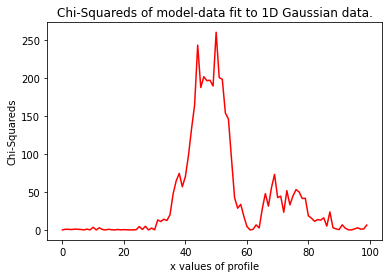

<Figure size 432x288 with 0 Axes>

In [10]:
chi_squared_map = (normalized_residual_map) ** 2
plt.plot(xvalues, chi_squared_map, color="r")
plt.title("Chi-Squareds of model-data fit to 1D Gaussian data.")
plt.xlabel("x values of profile")
plt.ylabel("Chi-Squareds")
plt.show()
plt.clf()

Great, even when looking at a chi-squared-map its clear that our model gives a rubbish fit to the data.

Finally, we want to reduce all the information in our `chi_squared_map` into a single goodness-of-fit measure. To do
this we define the `chi-squared`, which is the sum of all values on the chi-squared-map.

In [11]:
chi_squared = np.sum(chi_squared_map)
print("Chi-squared = ", chi_squared)

Chi-squared =  4021.8143579829803


The lower our chi-squared, the fewer residuals in the fit between our model and the data and therefore the better our 
fit!

From the chi-squared we can then define our final goodness-of-fit measure, the `log_likelihood`, which is the
chi-squared value times -0.5.

In [12]:
log_likelihood = -0.5 * chi_squared
print("Log Likelihood = ", log_likelihood)

Log Likelihood =  -2010.9071789914901


Why is the log likelihood the chi-squared times -0.5? Lets not worry about. This is simply the standard definition of a
log_likelihood in statistics (it relates to the noise-properties of our data-set). For now, just accept that this is 
what a log likelihood is and if we want to fit a model to data our goal is to thus find the combination of model 
parameters that maximizes our `log_likelihood`.

There is a second quantity that enters the log likelihood, called the `noise-normalization`. This is the log sum of all
noise values squared in our data (given the noise-map is fixed, the noise_normalization retains the same value for
all models that we fit. Nevertheless, it is good practise to include it in the log likelihood).

In [13]:
noise_normalization = np.sum(np.log(2 * np.pi * noise_map ** 2.0))

Again, like the definition of a log likelihood, lets not worry about why a noise normalization is defined in this way 
or why its in our goodness-of-fit. Lets just accept for now that this is how it is in statistics.

Thus, we now have the definition of a log likelihood that we'll use hereafter in all **PyAutoFit** tutorials.

In [14]:
log_likelihood = -0.5 * (chi_squared + noise_normalization)
print("Log Likelihood = ", log_likelihood)

Log Likelihood =  -1780.9134498251374


If you are familiar with model-fitting, you'll have probably heard of terms like 'residuals', 'chi-squared' and
'log_likelihood' before. These are the standard metrics by which a model-fit`s quality is measured. They are used for
model fitting in general, so not just when your data is 1D but when its a 2D image, 3D datacube or something else
entirely!

If you haven't performed model fitting before and these terms are new to you, make sure you are clear on exactly what
they all mean as they are at the core of all model-fitting performed in **PyAutoFit**!

So to recap the previous tutorial and this one:
    
 - We can define a model components in **PyAutoFit**, like our `Gaussian`, using Python classes that follow a certain 
 format.
 
 - The model component's parameters each have priors, which given a unit vector can be mapped to an instance of the
 `Gaussian` class.
 
 - We can use this model instance to create model data of our `Gaussian` and compare it to data and quantify the
 goodness-of-fit via a log likelihood.

Thus we have everything we need to fit our model to our data! So, how do we go about finding the best-fit model?
That is, the model which maximizes the log likelihood.

The most simple thing we can do is guess parameters, and when we guess parameters that give a good fit, guess another
set of parameters near those values. We can then repeat this process, over and over, until we find a really good model!

For our `Gaussian` this works pretty well, below I've fitted 5 different `Gaussian` models and ended up landing on
the best-fit model (the model I used to create the `Dataset` in the first place!).

For convenience, I've create functions which compute the chi-squared-map and log likelihood of a model-fit, alongside a
method to plot a profile, residual-map or chi-squared-map.

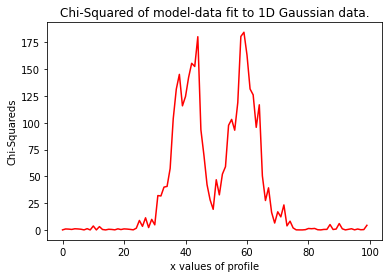

Log Likelihood:
-1568.6236490714537


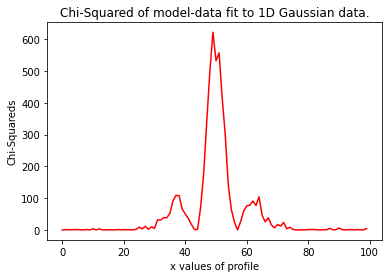

Log Likelihood:
-2377.7912078785425


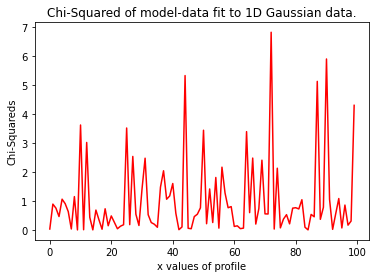

Log Likelihood:
179.09579237214166


<Figure size 432x288 with 0 Axes>

In [15]:


def chi_squared_map_from_data_and_model_data(data, noise_map, model_data):

    residual_map = data - model_data
    normalized_residual_map = residual_map / noise_map

    return (normalized_residual_map) ** 2


def log_likelihood_from_data_and_model_data(data, noise_map, model_data):

    chi_squared_map = chi_squared_map_from_data_and_model_data(
        data=data, noise_map=noise_map, model_data=model_data
    )
    chi_squared = sum(chi_squared_map)
    noise_normalization = np.sum(np.log(2 * np.pi * noise_map ** 2.0))
    log_likelihood = -0.5 * (chi_squared + noise_normalization)

    return log_likelihood


def plot_line(xvalues, line, color="k", errors=None, ylabel=None):

    plt.errorbar(
        x=xvalues, y=line, yerr=errors, color=color, ecolor="k", elinewidth=1, capsize=2
    )
    plt.title("Chi-Squared of model-data fit to 1D Gaussian data.")
    plt.xlabel("x values of profile")
    plt.ylabel(ylabel)
    plt.show()
    plt.clf()


gaussian = model.instance_from_vector(vector=[50.0, 10.0, 5.0])
model_data = gaussian.profile_from_xvalues(xvalues=xvalues)
chi_squared_map = chi_squared_map_from_data_and_model_data(
    data=data, noise_map=noise_map, model_data=model_data
)
plot_line(xvalues=xvalues, line=chi_squared_map, color="r", ylabel="Chi-Squareds")

log_likelihood = log_likelihood_from_data_and_model_data(
    data=data, noise_map=noise_map, model_data=model_data
)
print("Log Likelihood:")
print(log_likelihood)

gaussian = model.instance_from_vector(vector=[50.0, 25.0, 5.0])
model_data = gaussian.profile_from_xvalues(xvalues=xvalues)
chi_squared_map = chi_squared_map_from_data_and_model_data(
    data=data, noise_map=noise_map, model_data=model_data
)
plot_line(xvalues=xvalues, line=chi_squared_map, color="r", ylabel="Chi-Squareds")

log_likelihood = log_likelihood_from_data_and_model_data(
    data=data, noise_map=noise_map, model_data=model_data
)
print("Log Likelihood:")
print(log_likelihood)

gaussian = model.instance_from_vector(vector=[50.0, 25.0, 10.0])
model_data = gaussian.profile_from_xvalues(xvalues=xvalues)
chi_squared_map = chi_squared_map_from_data_and_model_data(
    data=data, noise_map=noise_map, model_data=model_data
)
plot_line(xvalues=xvalues, line=chi_squared_map, color="r", ylabel="Chi-Squareds")

log_likelihood = log_likelihood_from_data_and_model_data(
    data=data, noise_map=noise_map, model_data=model_data
)
print("Log Likelihood:")
print(log_likelihood)

You can now perform model-fitting with **PyAutoFit**! All we have to do is guess lots of parameters, over and over and
over again, until we hit a model with a high log_likelihood. Yay!

Of course, you're probably thinking, is that really it? Should we really be guessing models to find the best-fit?

Obviously, the answer is no. Imagine our model was more complex, that it had many more parameters than just 3.
Our approach of guessing parameters won't work - it could take days, maybe years, to find models with a high
log_likelihood, and how could you even be sure they ware the best-fit models? Maybe a set of parameters you never tried
provide an even better fit?

Of course, there is a much better way to perform model-fitting, and in the next tutorial we'll take you through how
to do such fitting in **PyAutoFit**, using a `NonLinearSearch`.

__Your Model__

To end, its worth quickly thinking about the model you ultimately want to fit with **PyAutoFit**. In this example,
we extended the `Gaussian` class to contain the function we needed to generate an image of the `Gaussian` and thus
generate the model-image we need to fit our data. For your model fitting problem can you do something similar?
Or is your model-fitting task a bit more complicated than this? Maybe there are more model component you want to
combine or there is an inter-dependency between models?

**PyAutoFit** provides a lot of flexibility in how you use your model instances, so whatever your problem you should 
find that it is straight forward to find a solution. But, whatever you need to do at its core your modeling problem 
will break down into the tasks we did in this tutorial:

- Use your model to create some model data.
- Subtract it from the data to create residuals.
- Use these residuals in conjunction with your noise-map to define a log likelihood.
- Find the highest log likelihood models.

So, get thinking about how these steps would be performed for your model!